### Objective: In this notebook we will do some modeling

- Anthony is doing Logistic Ridge. 
- Tong is doing is doing Gradient boosted
- I am doing Logistic Lasso. 

### Load the modules and data


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 999)
%matplotlib inline

In [2]:
def load_features(path):
    """loads the features of the data and removes undesired columns """
    
    remove = ['channel 4 RIR 1 ', 'channel 4 RIR 2 ', 'channel 4 RIR 3 ', 'channel 4 RIR 4 ', 'channel 4 RIR 5 ',
              'channel 4 RIR 6 ', 'channel 10 RIR 1 ', 'channel 10 RIR 2 ', 'channel 10 RIR 3 ', 'channel 10 RIR 4 ',
              'channel 10 RIR 5 ', 'channel 10 RIR 6 ', 'SpectralEntropy 4', 'SpectralEntropy 10']
    
    # read in the data 
    data =pd.read_csv(path)
        
    # drop the undesired columns 
    return data.drop(remove, axis = 1)

In [3]:
base = join('/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG','data_local')
data = load_features(join(base,'training.csv'))
meta_data = pd.read_csv(join(base,'train_and_test_data_labels_safe.csv'))

#### remove rows that are not uses

In [48]:
# filter on the data that is safe
def create_file_name(x):
    numbers = map(int,x.iloc[ -3:] )
    string = '_'.join(map(str, numbers ))
    return '.'.join([string, 'mat'])

file_names = data.apply(create_file_name, axis = 1)
safe = meta_data.query('safe==1').image

data = data.query('@file_names in @safe')
data.to_csv(join(base,'cleaned_training.csv'), index = False)

### clean up the data by removing columns that have nan

### What is the dummy model? 

The dummy model will just always say that that it is not pre-ictal. 

In [6]:
data.pre_ictal.value_counts()/len(data)

0    0.903639
1    0.096361
Name: pre_ictal, dtype: float64

### Now for the modeling using ridge regression.

The first thing I will do this with the following strategy.

- First, I will take random sampling for test and train, and use the default parameters with L2 regression.
- I will then evalute with AUC. 

- Following that I will do the gradient search. 

#### Load more modules

In [7]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, make_scorer

#### Split the data

In [8]:
X = data.iloc[:, :-3].copy()
y = data.iloc[:,-1].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=4)

#### Set up the classifier and then fit it

In [9]:
clf1= LogisticRegression(penalty = 'l1',
                         C = 1.0, 
                         fit_intercept =True,
                         verbose = True)

clf1.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=True, warm_start=False)

In [10]:
clf1.score(X_test, y_test)

0.91273821464393179

#### plot an roc_curve


In [11]:
def plot_roc(y_test, y_probs, lw = 1.2):
    '''plots an roc curve
    Parameters: 
        y_test(iterable): an array with the real labels
        y_probs(iterable): an array containing the prediction probs from 
        classifier
    Returns: 
        None
    '''
    
    fpr, tpr, _= roc_curve(y_test, y_probs)
    ax = plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    
    return None
    

In [12]:
y_probs1 = [pred[1] for pred in clf1.predict_proba(X_test)]

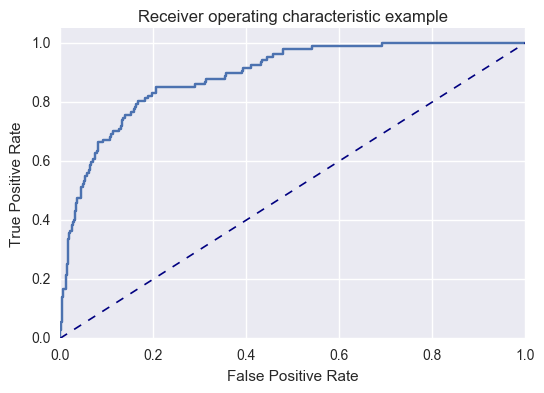

In [13]:
plot_roc(y_test, y_probs1)

In [14]:
roc_auc_score(y_test, y_probs1)

0.88958311456473804

### Try with undersampling
I am using the undersampling methods from imbalanced-learn. This is a libarary that Tong found. 

In [15]:
from imblearn.under_sampling import OneSidedSelection
from collections import Counter

/Users/crivera5/.virtual_envs/Kaggle/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
oss = OneSidedSelection(random_state = 42)
X_down, y_down = oss.fit_sample(X,y)

In [17]:
Counter(y)

Counter({0: 3601, 1: 384})

In [18]:
Counter(y_down)

Counter({0: 3528, 1: 384})

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_down,y_down,random_state=4)

In [20]:
clf2 = LogisticRegression(penalty = 'l1',
                         C = 1.0, 
                         fit_intercept =True,
                         verbose = True)

clf2.fit(X_train2, y_train2)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=True, warm_start=False)

In [21]:
y_probs2 = [pred[1] for pred in clf2.predict_proba(X_test2)]

In [22]:
roc_auc_score(y_test2, y_probs2)

0.85688740537640817

### A general fuction for plotting the roc curves`

In [33]:
model_data = {
    'Logistic with Lasso': {'obs':y_test, 'probs': y_probs1}, 
    'Logisitc with Lasso and downsampling': {'obs':y_test2, 'probs': y_probs2}
}

In [24]:
def plot_roc_curves(model_data, lw = 0.8):
    '''plots an roc curve
    Parameters: 
        model_data: dicts obs and probs
        classifier
    Returns: 
        None
    '''
    for model in model_data:
        print model
        obs = model_data[model]['obs']
        probs = model_data[model]['probs']
        fpr, tpr, _= roc_curve(obs, probs)
        
        plt.plot(fpr, tpr,label = model, lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curves')
    plt.legend(loc = 0)
    
    return None
    

Logisitc with Lasso and downsampling
Logistic with Lasso


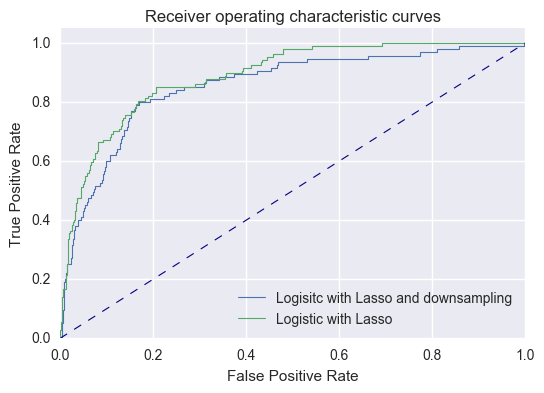

In [25]:
plot_roc_curves(model_data)

### Try with scaling first
Its best to do this for the performance.  I am using the first split. 

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
scalar = StandardScaler()
X_train1_scaled = scalar.fit_transform(X_train)
# refit the data
clf3 = LogisticRegression(penalty = 'l1',
                         C = 1.0, 
                         fit_intercept =True,
                         verbose = True)
clf3.fit(X_train1_scaled,y_train)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=True, warm_start=False)

In [28]:
X_test_scaled = scalar.transform(X_test)
y_probs3 = [pred[1] for pred in clf3.predict_proba(X_test_scaled)]

In [34]:
model_data['Lasso Logistic with Scaling']= {'obs':y_test, 'probs': y_probs3}

Logisitc with Lasso and downsampling
Lasso Logistic with Scaling
Logistic with Lasso


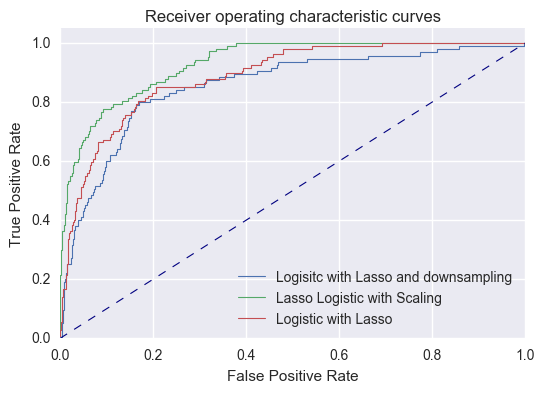

In [35]:
plot_roc_curves(model_data)

#### Look at the metrics for the lasso Logistic with scaling

In [37]:
roc_auc_score(y_test, y_probs3)

0.93175469914942766

In [38]:
clf3.score(X_test_scaled, y_test)

0.93179538615847546

In [39]:
confusion_matrix(y_test, clf3.predict(X_test_scaled))

array([[870,  20],
       [ 48,  59]])

The third model is pretty sure when a times series corresponds to an interictal state. But its confused when it sees an pre-ictal one. 

### Create a pipeline for doing the cross validation
For this I will not down sample the data.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Using a pipeline with gridsearch
I tried to use the LogisticRegressionCV with AUC. It did not work as desired. Below, I am using the gridsearchCV. 

#### Use the pipeline first

I am just testing the pipeline. 

In [41]:
scalar = StandardScaler()
clf = LogisticRegression(C = 1.0,
                          class_weight = 'balanced',
                          penalty = 'l1',
                          n_jobs = -1,
                          verbose = True,
                          random_state = 444,
                          solver = 'liblinear')
pipeline= Pipeline(steps = [('scaler',scalar), ('Logistic',clf)])



In [42]:
pipeline.fit(X_train,y_train)

[LibLinear]

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=444,
          solver='liblinear', tol=0.0001, verbose=True, warm_start=False))])

In [43]:
y_probs4 = [pred[1] for pred in pipeline.predict_proba(X_test)]

In [44]:
roc_auc_score(y_test, y_probs4)

0.93245825895201095

In [45]:
model_data['Lasso Logistic using Pipeline']= {'obs':y_test, 'probs': y_probs4}

Logisitc with Lasso and downsampling
Lasso Logistic with Scaling
Lasso Logistic using Pipeline
Logistic with Lasso


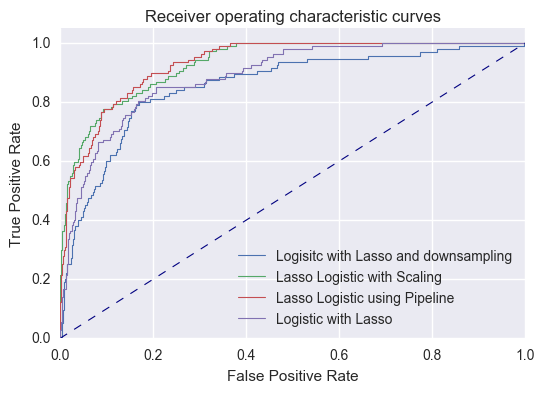

In [46]:
plot_roc_curves(model_data)

### Remarks 
I am doing additional modeling with a pipeline in the next notebook. Chris Modeling 2. 